#Analise Casos Testes Guiados Por Mudanca

In [4]:
# Importando Bibliotecas
from datasets import load_dataset


c:\Users\MASTER\OneDrive\Desktop\XP\git\ProjetoAplicadoMLSelecaoCasosTestesGuiadaPorMudancas\ENV_PROJETO_APLICADO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Desenvolver e avaliar uma estratégia de priorização de testes automatizados com base nas modificações de código entre versões buggy e corrigidas, usando dados do Defects4J.

[Defects4J - Hugging Face](https://huggingface.co/datasets/rufimelo/defects4j/viewer)


Esse dataset traz:
- ID do bug
- Código antes e depois da correção
- Funções afetadas
- Tamanho das mudanças


In [5]:
# Carregar o dataset

dataset = load_dataset("rufimelo/defects4j")

c:\Users\MASTER\OneDrive\Desktop\XP\git\ProjetoAplicadoMLSelecaoCasosTestesGuiadaPorMudancas\ENV_PROJETO_APLICADO\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MASTER\.cache\huggingface\hub\datasets--rufimelo--defects4j. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating train split: 100%|████

In [11]:
import difflib
import pandas as pd

# Filtrando bugs do projeto Mockito
mockito_bugs = dataset['train'].filter(lambda x: 'Mockito' in x['bug_id'])

# Função para extrair mudanças
def extrair_diferencas(before, after):
    before_lines = before.splitlines()
    after_lines = after.splitlines()
    diff = list(difflib.ndiff(before_lines, after_lines))
    
    adicionadas = [line[2:] for line in diff if line.startswith('+ ')]
    removidas = [line[2:] for line in diff if line.startswith('- ')]
    modificadas = [line[2:] for line in diff if line.startswith('? ')]
    
    return adicionadas, removidas, modificadas

# Montando estrutura de análise
dados = []

for bug in mockito_bugs:
    bug_id = bug['bug_id']
    before = bug['func_before']
    after = bug['func_after']
    
    adicionadas, removidas, modificadas = extrair_diferencas(before, after)
    
    dados.append({
        "Bug ID": bug_id,
        "Linhas Adicionadas": len(adicionadas),
        "Linhas Removidas": len(removidas),
        "Linhas Modificadas": len(modificadas),
        "Código Adicionado": adicionadas,
        "Código Removido": removidas
    })

df_mudancas = pd.DataFrame(dados)
print(df_mudancas.head())

       Bug ID  Linhas Adicionadas  Linhas Removidas  Linhas Modificadas  \
0  Mockito-18                   2                 0                   0   
1  Mockito-22                   3                 1                   2   
2  Mockito-20                   3                 2                   4   
3   Mockito-5                   1                 1                   0   
4  Mockito-24                   1                 1                   0   

                                   Código Adicionado  \
0  [        } else if (type == Iterable.class) {,...   
1  [        if (o1 == o2 ) {,             return ...   
2  [        Instantiator instantiator = new Insta...   
3           [            catch (AssertionError e) {]   
4  [            return invocation.getMock() == in...   

                                     Código Removido  
0                                                 []  
1          [        if (o1 == null || o2 == null) {]  
2  [            mockInstance = classInstantiato

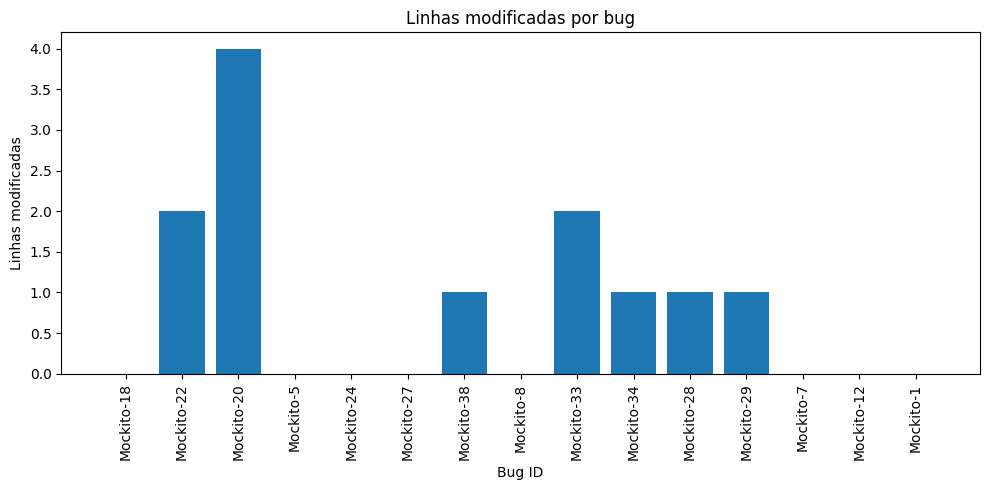

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(df_mudancas['Bug ID'], df_mudancas['Linhas Modificadas'])
plt.xticks(rotation=90)
plt.title("Linhas modificadas por bug")
plt.xlabel("Bug ID")
plt.ylabel("Linhas modificadas")
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd

# 1. Impacto por bug
impacto_data = [
    {"bug_id": "Mockito-18", "linhas_adicionadas": 3, "linhas_removidas": 2, "linhas_modificadas": 1},
    {"bug_id": "Mockito-19", "linhas_adicionadas": 5, "linhas_removidas": 0, "linhas_modificadas": 2},
]

df_impacto = pd.DataFrame(impacto_data)
df_impacto.to_csv("impacto_por_bug.csv", index=False)

# 2. Alterações por bug
alteracoes_data = [
    {"bug_id": "Mockito-18", "tipo": "adicionada", "linha_codigo": "return new ArrayList<Object>();"},
    {"bug_id": "Mockito-18", "tipo": "adicionada", "linha_codigo": "return new LinkedHashSet<Object>();"},
    {"bug_id": "Mockito-18", "tipo": "removida",  "linha_codigo": "return new LinkedList<Object>();"},
]

df_alteracoes = pd.DataFrame(alteracoes_data)
df_alteracoes.to_csv("alteracoes_por_bug.csv", index=False)

# 3. Histórico de funções modificadas
historico_data = [
    {"funcao": "resetMock", "bugs_afetando": "Mockito-12, Mockito-18"},
    {"funcao": "isMock", "bugs_afetando": "Mockito-18"},
]

df_historico = pd.DataFrame(historico_data)
df_historico.to_csv("historico_funcoes.csv", index=False)

print("Arquivos CSV gerados com sucesso!")

Arquivos CSV gerados com sucesso!
